In [30]:
import torchvision
import torch
from torch import Tensor
from plots import plot_training_result, plot_image_data
from torch.utils.data import ConcatDataset

from vae.mnist_vae import VaeAutoencoderClassifier
from image_classifier.image_classifier import MNISTClassifier
from utils import frechet_inception_distance

In [44]:
training_data = torchvision.datasets.MNIST(root='../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0
labels = training_data.targets[:60000]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


In [45]:
# Train VAE
vae = VaeAutoencoderClassifier(dim_encoding=2)

# merged_dataset = ConcatDataset([training_data, testing_data])
# print(merged_dataset)

# alpha value of 5000 and 20 epochs seems to be the best
# increasing alpha will decrease KL divergence loss but worse generated data
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae.train_model(
    training_data,
    batch_size=100,
    alpha=5000.0,
    epochs=20
)

# # example of how to later aggregate weights and bias
# vae2 = VaeAutoencoderClassifier(dim_encoding=2)
# avg_parameter = torch.nn.Parameter((vae.encoder.fc1.weight + vae2.encoder.fc1.weight) / 2)

Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10
Finished epoch:  11
Finished epoch:  12
Finished epoch:  13
Finished epoch:  14
Finished epoch:  15
Finished epoch:  16
Finished epoch:  17
Finished epoch:  18
Finished epoch:  19
Finished epoch:  20


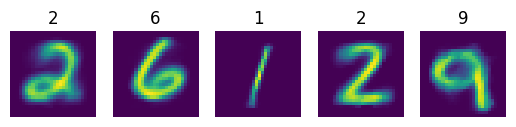

In [55]:
# plot generated data
image_tensor, label_tensor = vae.generate_data(n_samples=5)
plot_image_data(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

In [47]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


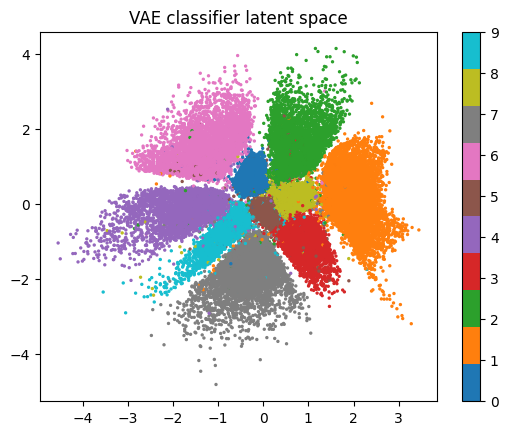

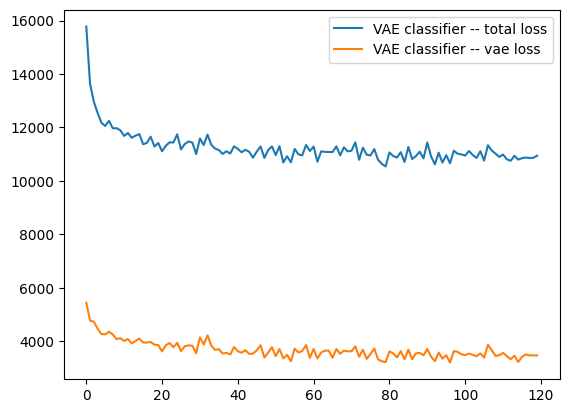

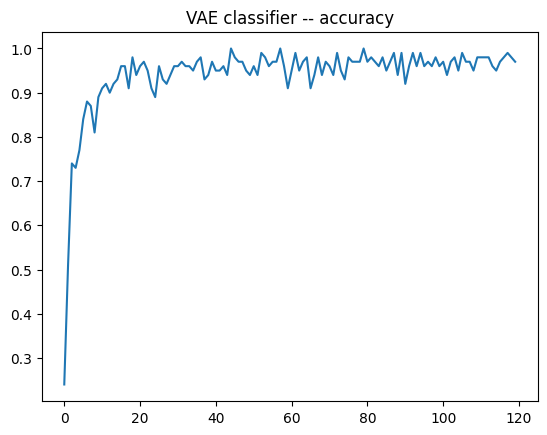

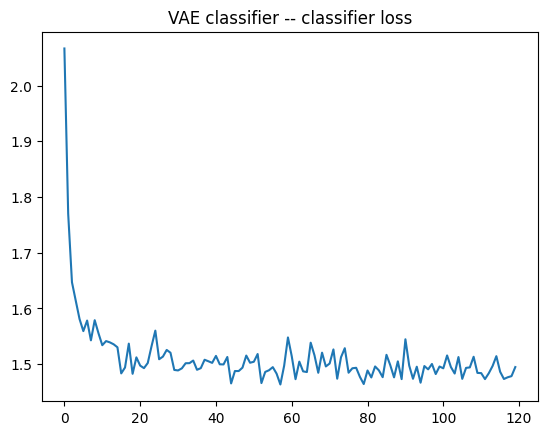

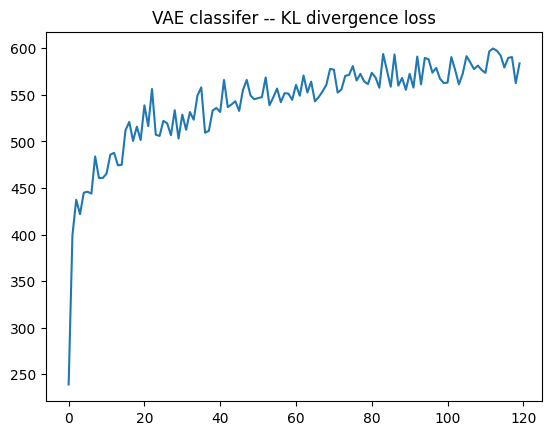

In [48]:
# plot results
plot_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [37]:
# train classifier for performance evaluation

classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=100, epochs=5)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Test accuracy:  0.9745


In [49]:
x, y = vae.generate_data(n_samples=1)

for i in range(100):
    image_tensor, label_tensor = vae.generate_data(n_samples=100)
    x = torch.cat((x, image_tensor), dim=0)
    y = torch.cat((y, label_tensor), dim=0)

assert x.shape[0] == y.shape[0]
print("Number of images: ", x.shape[0])

Number of images:  10001


In [50]:
# test image classification with gen images
accuracy = classifier.test_model_syn_img(x, y)
print("Accuracy: ", accuracy)

Accuracy:  0.9559044095590441


In [42]:
# compute FID score
syn_input, _ = vae.generate_data(n_samples=500)
input = input[:500]

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score (worst: 131, best: 85)
# 0 score only possible if absolutely identical
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

KeyboardInterrupt: 

In [58]:
# compare distribution of input vs distribution of generated images
counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print(labels)
print(labels.shape)
for label in labels:
    counts[label]+=1
    
_, gen_output = vae.generate_data(n_samples=60000)
gen_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for probabilities in gen_output:
    max_index = torch.argmax(probabilities)
    gen_counts[max_index]+=1
    
print(counts)
print(gen_counts)


tensor([5, 0, 4,  ..., 5, 6, 8])
torch.Size([60000])
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
[6362, 6072, 5830, 6766, 6226, 4330, 5403, 6031, 6049, 6931]
